# Fase 4: Blocking Strategies

Questo notebook implementa e confronta diverse strategie di blocking per ridurre lo spazio di confronto tra i dataset.

## Obiettivi
1. Implementare B1 (Standard Blocking): year + manufacturer
2. Implementare B2 (Extended Blocking): year + manufacturer + model_prefix
3. Valutare l'efficacia delle strategie di blocking
4. Confrontare riduzione dello spazio di ricerca e pair completeness

## 1. Setup e Import

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Aggiungi src al path
sys.path.append('..')

# Import moduli custom
from src.blocking import StandardBlocking, ExtendedBlocking, BlockingEvaluator

# Configurazione visualizzazioni
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Librerie importate con successo")

✓ Librerie importate con successo


## 2. Caricamento Dati

In [2]:
# Carica i dataset campionati dalla Fase 3 (per coerenza con ground truth)
print("Caricamento dataset campionati da Fase 3...")
df_craigslist = pd.read_csv('../data/processed/craigslist_sample.csv')
df_usedcars = pd.read_csv('../data/processed/usedcars_sample.csv')

# Aggiungi record_id se non presente (dovrebbe già esserci dalla Fase 3)
if 'record_id' not in df_craigslist.columns:
    df_craigslist['record_id'] = 'craigslist_' + df_craigslist.index.astype(str)
if 'record_id' not in df_usedcars.columns:
    df_usedcars['record_id'] = 'usedcars_' + df_usedcars.index.astype(str)

print(f"✓ Craigslist: {len(df_craigslist):,} records")
print(f"✓ UsedCars: {len(df_usedcars):,} records")
print("\n Usando campioni dalla Fase 3 per coerenza con ground truth")
print(f"Coppie totali possibili: {len(df_craigslist) * len(df_usedcars):,}")

Caricamento dataset campionati da Fase 3...
✓ Craigslist: 10,000 records
✓ UsedCars: 50,000 records

 Usando campioni dalla Fase 3 per coerenza con ground truth
Coppie totali possibili: 500,000,000


In [3]:
# Carica ground truth per valutazione
gt_train = pd.read_csv('../data/ground_truth/train.csv')
gt_val = pd.read_csv('../data/ground_truth/validation.csv')
gt_test = pd.read_csv('../data/ground_truth/test.csv')

# Combina per avere il ground truth completo
ground_truth = pd.concat([gt_train, gt_val, gt_test], ignore_index=True)

print(f"Ground Truth records: {len(ground_truth):,}")
print(f"  Matches: {(ground_truth['label'] == 1).sum():,}")
print(f"  Non-matches: {(ground_truth['label'] == 0).sum():,}")

Ground Truth records: 8
  Matches: 4
  Non-matches: 4


In [4]:
# Alias per compatibilità con il resto del notebook
df_craigslist_sample = df_craigslist
df_usedcars_sample = df_usedcars

## 3. Analisi delle Chiavi di Blocking

Prima di applicare il blocking, analizziamo la distribuzione delle chiavi.

In [5]:
# Analizza distribuzione year
print("=" * 60)
print("DISTRIBUZIONE YEAR")
print("=" * 60)
print("\nCraigslist:")
print(df_craigslist_sample['year'].describe())
print(f"Valori unici: {df_craigslist_sample['year'].nunique()}")
print(f"Valori nulli: {df_craigslist_sample['year'].isna().sum()}")

print("\nUsedCars:")
print(df_usedcars_sample['year'].describe())
print(f"Valori unici: {df_usedcars_sample['year'].nunique()}")
print(f"Valori nulli: {df_usedcars_sample['year'].isna().sum()}")

DISTRIBUZIONE YEAR

Craigslist:
count    9974.000000
mean     2011.349609
std         9.181263
min      1903.000000
25%      2008.000000
50%      2013.000000
75%      2017.000000
max      2022.000000
Name: year, dtype: float64
Valori unici: 86
Valori nulli: 26

UsedCars:
count    50000.000000
mean      2017.730560
std          4.115417
min       1935.000000
25%       2017.000000
50%       2020.000000
75%       2020.000000
max       2021.000000
Name: year, dtype: float64
Valori unici: 62
Valori nulli: 0


In [6]:
# Analizza distribuzione manufacturer
print("=" * 60)
print("DISTRIBUZIONE MANUFACTURER")
print("=" * 60)
print("\nCraigslist:")
print(f"Valori unici: {df_craigslist_sample['manufacturer'].nunique()}")
print(f"Valori nulli: {df_craigslist_sample['manufacturer'].isna().sum()}")
print("\nTop 10 manufacturers:")
print(df_craigslist_sample['manufacturer'].value_counts().head(10))

print("\nUsedCars:")
print(f"Valori unici: {df_usedcars_sample['manufacturer'].nunique()}")
print(f"Valori nulli: {df_usedcars_sample['manufacturer'].isna().sum()}")
print("\nTop 10 manufacturers:")
print(df_usedcars_sample['manufacturer'].value_counts().head(10))

DISTRIBUZIONE MANUFACTURER

Craigslist:
Valori unici: 39
Valori nulli: 389

Top 10 manufacturers:
manufacturer
ford         1636
chevrolet    1341
toyota        824
honda         476
nissan        451
ram           437
jeep          433
gmc           406
bmw           349
dodge         327
Name: count, dtype: int64

UsedCars:
Valori unici: 58
Valori nulli: 0

Top 10 manufacturers:
manufacturer
ford         7869
chevrolet    6176
toyota       4056
nissan       3647
honda        3555
jeep         2759
hyundai      2301
kia          1857
ram          1729
gmc          1699
Name: count, dtype: int64


In [7]:
# Analizza distribuzione model
print("=" * 60)
print("DISTRIBUZIONE MODEL")
print("=" * 60)
print("\nCraigslist:")
print(f"Valori unici: {df_craigslist_sample['model'].nunique()}")
print(f"Valori nulli: {df_craigslist_sample['model'].isna().sum()}")
print("\nTop 10 models:")
print(df_craigslist_sample['model'].value_counts().head(10))

print("\nUsedCars:")
print(f"Valori unici: {df_usedcars_sample['model'].nunique()}")
print(f"Valori nulli: {df_usedcars_sample['model'].isna().sum()}")
print("\nTop 10 models:")
print(df_usedcars_sample['model'].value_counts().head(10))

DISTRIBUZIONE MODEL

Craigslist:
Valori unici: 3509
Valori nulli: 112

Top 10 models:
model
f-150             199
silverado 1500    122
1500              108
accord             70
tacoma             69
camry              68
escape             68
2500               67
grand cherokee     66
silverado          64
Name: count, dtype: int64

UsedCars:
Valori unici: 789
Valori nulli: 0

Top 10 models:
model
F-150             2094
1500              1175
Silverado 1500    1173
Equinox           1059
Escape             958
Explorer           810
Rogue              808
Camry              744
Grand Cherokee     732
Fusion             717
Name: count, dtype: int64


## 4. Strategia B1: Standard Blocking

Blocking basato su **year** e **manufacturer**.

In [8]:
# Inizializza e applica B1
print("=" * 60)
print("B1: STANDARD BLOCKING (year + manufacturer)")
print("=" * 60)
print()

b1_strategy = StandardBlocking(block_on=['year', 'manufacturer'])
pairs_b1 = b1_strategy.generate_pairs(df_craigslist_sample, df_usedcars_sample)

B1: STANDARD BLOCKING (year + manufacturer)

B1-Standard Blocking:
  Coppie totali possibili: 500,000,000
  Coppie candidate: 59,308,271
  Riduzione: 88.14%


In [9]:
# Calcola metriche B1 (senza ground truth - dataset campionati)
total_possible = len(df_craigslist_sample) * len(df_usedcars_sample)
reduction_b1 = 1 - (len(pairs_b1) / total_possible)

metrics_b1 = {
    'total_candidate_pairs': len(pairs_b1),
    'total_possible_pairs': total_possible,
    'reduction_ratio': reduction_b1,
    'pairs_to_compare_ratio': len(pairs_b1) / total_possible
}

print("\n" + "=" * 60)
print("METRICHE B1")
print("=" * 60)
print(f"Coppie candidate: {metrics_b1['total_candidate_pairs']:,}")
print(f"Coppie totali possibili: {metrics_b1['total_possible_pairs']:,}")
print(f"Reduction ratio: {metrics_b1['reduction_ratio']:.4f} ({metrics_b1['reduction_ratio']*100:.2f}%)")
print(f"Pairs to compare ratio: {metrics_b1['pairs_to_compare_ratio']:.6f}")


METRICHE B1
Coppie candidate: 59,308,271
Coppie totali possibili: 500,000,000
Reduction ratio: 0.8814 (88.14%)
Pairs to compare ratio: 0.118617


## 5. Strategia B2: Extended Blocking

Blocking basato su **year**, **manufacturer** e **model_prefix** (primi 3 caratteri).

In [10]:
# Inizializza e applica B2
print("=" * 60)
print("B2: EXTENDED BLOCKING (year + manufacturer + model_prefix)")
print("=" * 60)
print()

b2_strategy = ExtendedBlocking(block_on=['year', 'manufacturer'], model_prefix_len=3)
pairs_b2 = b2_strategy.generate_pairs(df_craigslist_sample, df_usedcars_sample)

B2: EXTENDED BLOCKING (year + manufacturer + model_prefix)

B2-Extended Blocking:
  Coppie totali possibili: 500,000,000
  Coppie candidate: 59,995,106
  Riduzione: 88.00%


In [11]:
# Calcola metriche B2 (senza ground truth - dataset campionati)
reduction_b2 = 1 - (len(pairs_b2) / total_possible)

metrics_b2 = {
    'total_candidate_pairs': len(pairs_b2),
    'total_possible_pairs': total_possible,
    'reduction_ratio': reduction_b2,
    'pairs_to_compare_ratio': len(pairs_b2) / total_possible
}

print("\n" + "=" * 60)
print("METRICHE B2")
print("=" * 60)
print(f"Coppie candidate: {metrics_b2['total_candidate_pairs']:,}")
print(f"Coppie totali possibili: {metrics_b2['total_possible_pairs']:,}")
print(f"Reduction ratio: {metrics_b2['reduction_ratio']:.4f} ({metrics_b2['reduction_ratio']*100:.2f}%)")
print(f"Pairs to compare ratio: {metrics_b2['pairs_to_compare_ratio']:.6f}")


METRICHE B2
Coppie candidate: 59,995,106
Coppie totali possibili: 500,000,000
Reduction ratio: 0.8800 (88.00%)
Pairs to compare ratio: 0.119990


## 6. Confronto tra Strategie

In [12]:
# Crea tabella di confronto
comparison_df = pd.DataFrame({
    'Strategy': ['B1-Standard', 'B2-Extended'],
    'Candidate Pairs': [f"{metrics_b1['total_candidate_pairs']:,}", 
                        f"{metrics_b2['total_candidate_pairs']:,}"],
    'Reduction Ratio': [f"{metrics_b1['reduction_ratio']:.2%}", 
                        f"{metrics_b2['reduction_ratio']:.2%}"],
    'Pairs to Compare': [f"{metrics_b1['pairs_to_compare_ratio']:.4%}",
                         f"{metrics_b2['pairs_to_compare_ratio']:.4%}"]
})

print("\n" + "=" * 80)
print("CONFRONTO STRATEGIE DI BLOCKING")
print("=" * 80)
print(comparison_df.to_string(index=False))


CONFRONTO STRATEGIE DI BLOCKING
   Strategy Candidate Pairs Reduction Ratio Pairs to Compare
B1-Standard      59,308,271          88.14%         11.8617%
B2-Extended      59,995,106          88.00%         11.9990%


In [13]:
# Crea confronto numerico dettagliato
comparison_numeric = pd.DataFrame({
    'Metric': ['Candidate Pairs', 'Total Possible Pairs', 'Reduction Ratio', 'Pairs to Compare Ratio'],
    'B1-Standard': [
        f"{metrics_b1['total_candidate_pairs']:,}",
        f"{metrics_b1['total_possible_pairs']:,}",
        f"{metrics_b1['reduction_ratio']:.2%}",
        f"{metrics_b1['pairs_to_compare_ratio']:.6%}"
    ],
    'B2-Extended': [
        f"{metrics_b2['total_candidate_pairs']:,}",
        f"{metrics_b2['total_possible_pairs']:,}",
        f"{metrics_b2['reduction_ratio']:.2%}",
        f"{metrics_b2['pairs_to_compare_ratio']:.6%}"
    ]
})

print("\n" + "=" * 80)
print("CONFRONTO DETTAGLIATO")
print("=" * 80)
print(comparison_numeric.to_string(index=False))

# Analisi differenza
diff_pairs = metrics_b1['total_candidate_pairs'] - metrics_b2['total_candidate_pairs']
diff_reduction = (metrics_b2['reduction_ratio'] - metrics_b1['reduction_ratio']) * 100

print("\n" + "=" * 80)
print("ANALISI DIFFERENZE")
print("=" * 80)
print(f"B2 genera {abs(diff_pairs):,} coppie candidate {'in meno' if diff_pairs > 0 else 'in più'} rispetto a B1")
print(f"B2 ha una riduzione {abs(diff_reduction):.2f}% {'maggiore' if diff_reduction > 0 else 'minore'} rispetto a B1")


CONFRONTO DETTAGLIATO
                Metric B1-Standard B2-Extended
       Candidate Pairs  59,308,271  59,995,106
  Total Possible Pairs 500,000,000 500,000,000
       Reduction Ratio      88.14%      88.00%
Pairs to Compare Ratio  11.861654%  11.999021%

ANALISI DIFFERENZE
B2 genera 686,835 coppie candidate in più rispetto a B1
B2 ha una riduzione 0.14% minore rispetto a B1


## 7. Visualizzazioni

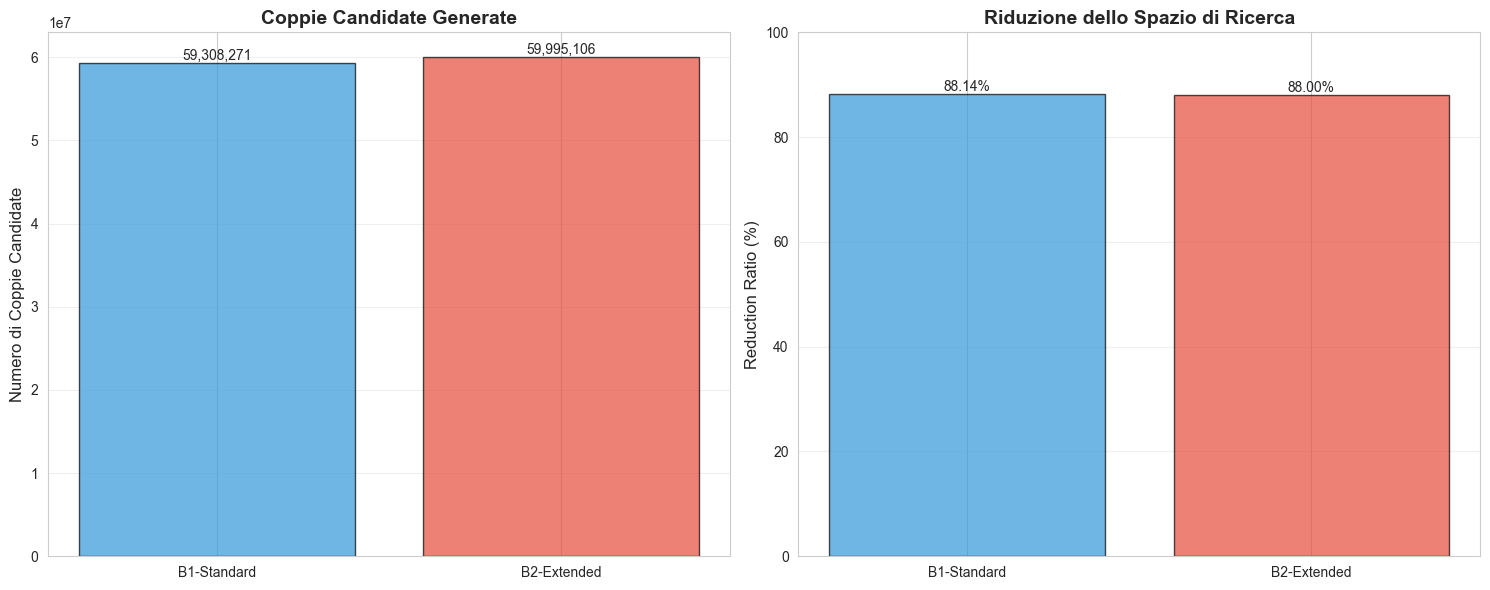

✓ Grafico salvato: blocking_comparison_candidates.png


In [14]:
# Grafico 1: Confronto coppie candidate
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Numero di coppie candidate
strategies = ['B1-Standard', 'B2-Extended']
candidate_pairs = [metrics_b1['total_candidate_pairs'], metrics_b2['total_candidate_pairs']]
colors = ['#3498db', '#e74c3c']

bars1 = ax1.bar(strategies, candidate_pairs, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Numero di Coppie Candidate', fontsize=12)
ax1.set_title('Coppie Candidate Generate', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Aggiungi valori sulle barre
for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10)

# Reduction ratio
reduction_ratios = [metrics_b1['reduction_ratio'] * 100, metrics_b2['reduction_ratio'] * 100]
bars2 = ax2.bar(strategies, reduction_ratios, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Reduction Ratio (%)', fontsize=12)
ax2.set_title('Riduzione dello Spazio di Ricerca', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 100])
ax2.grid(axis='y', alpha=0.3)

# Aggiungi valori sulle barre
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/visualizations/blocking_comparison_candidates.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato: blocking_comparison_candidates.png")

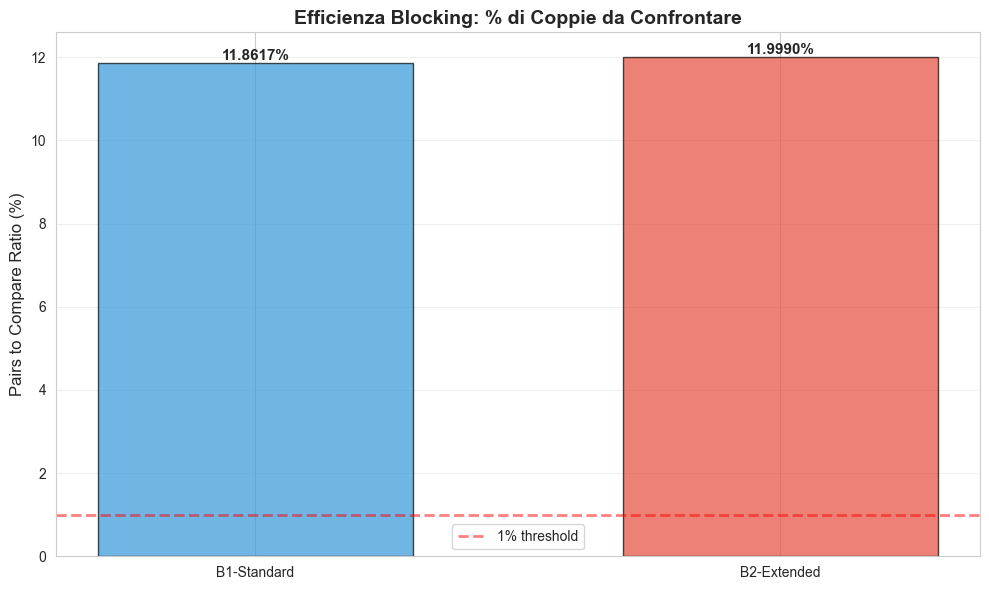

✓ Grafico salvato: blocking_comparison_efficiency.png


In [15]:
# Grafico 2: Confronto efficienza (Pairs to Compare Ratio)
fig, ax = plt.subplots(figsize=(10, 6))

pairs_ratios = [metrics_b1['pairs_to_compare_ratio'] * 100, 
                metrics_b2['pairs_to_compare_ratio'] * 100]

bars = ax.bar(strategies, pairs_ratios, color=colors, alpha=0.7, edgecolor='black', width=0.6)
ax.set_ylabel('Pairs to Compare Ratio (%)', fontsize=12)
ax.set_title('Efficienza Blocking: % di Coppie da Confrontare', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Aggiungi valori sulle barre
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.4f}%',
            ha='center', va='bottom', fontsize=11, fontweight='bold')

# Linea di riferimento
ax.axhline(y=1.0, color='red', linestyle='--', linewidth=2, alpha=0.5, 
           label='1% threshold')
ax.legend()

plt.tight_layout()
plt.savefig('../results/visualizations/blocking_comparison_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato: blocking_comparison_efficiency.png")

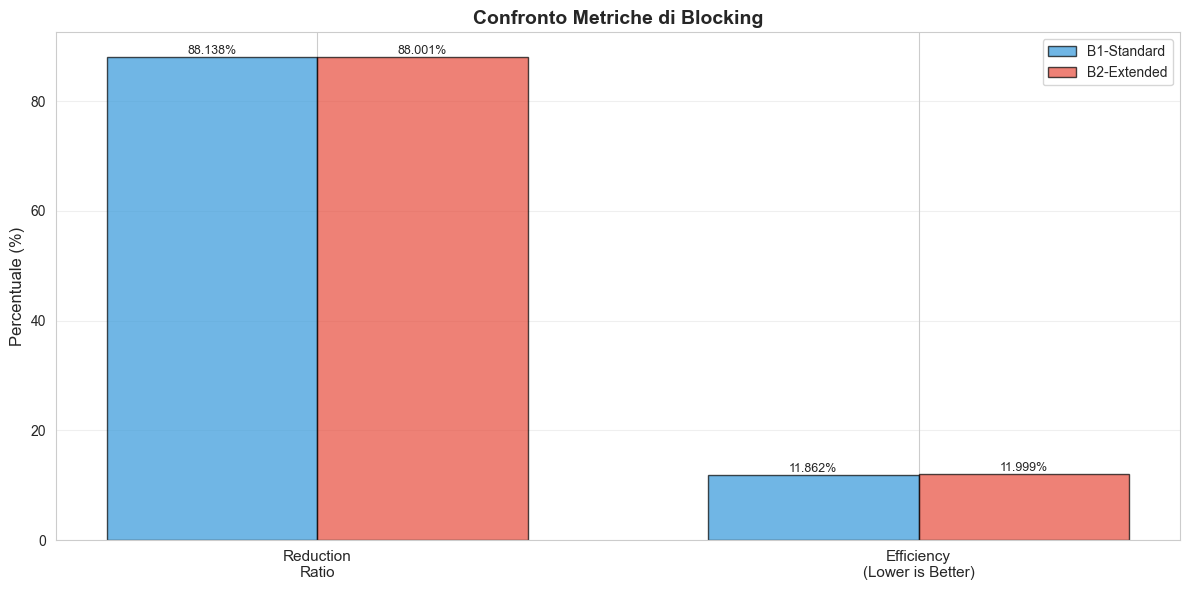

✓ Grafico salvato: blocking_metrics_comparison.png


In [16]:
# Grafico 3: Comparazione visiva delle metriche
fig, ax = plt.subplots(figsize=(12, 6))

metrics_names = ['Reduction\nRatio', 'Efficiency\n(Lower is Better)']
b1_values = [metrics_b1['reduction_ratio'] * 100, 
             metrics_b1['pairs_to_compare_ratio'] * 100]
b2_values = [metrics_b2['reduction_ratio'] * 100,
             metrics_b2['pairs_to_compare_ratio'] * 100]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax.bar(x - width/2, b1_values, width, label='B1-Standard',
               color='#3498db', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, b2_values, width, label='B2-Extended',
               color='#e74c3c', alpha=0.7, edgecolor='black')

ax.set_ylabel('Percentuale (%)', fontsize=12)
ax.set_title('Confronto Metriche di Blocking', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics_names, fontsize=11)
ax.legend()
ax.grid(axis='y', alpha=0.3)

# Aggiungi valori sulle barre
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}%',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('../results/visualizations/blocking_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Grafico salvato: blocking_metrics_comparison.png")

## 8. Salvataggio Risultati

In [17]:
# Salva metriche in un file di testo
report_path = Path('../results/blocking_strategies_report.txt')

with open(report_path, 'w', encoding='utf-8') as f:
    f.write("=" * 80 + "\n")
    f.write("BLOCKING STRATEGIES EVALUATION REPORT\n")
    f.write("=" * 80 + "\n\n")
    
    f.write("Dataset Information:\n")
    f.write("-" * 80 + "\n")
    f.write(f"Craigslist records (sample): {len(df_craigslist_sample):,}\n")
    f.write(f"UsedCars records (sample): {len(df_usedcars_sample):,}\n")
    f.write(f"Total possible pairs: {metrics_b1['total_possible_pairs']:,}\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("B1: STANDARD BLOCKING (year + manufacturer)\n")
    f.write("=" * 80 + "\n")
    f.write(f"Candidate pairs: {metrics_b1['total_candidate_pairs']:,}\n")
    f.write(f"Reduction ratio: {metrics_b1['reduction_ratio']:.4f} ({metrics_b1['reduction_ratio']*100:.2f}%)\n")
    f.write(f"Pairs to compare ratio: {metrics_b1['pairs_to_compare_ratio']:.6f} ({metrics_b1['pairs_to_compare_ratio']*100:.4f}%)\n")
    f.write("\n")
    
    f.write("=" * 80 + "\n")
    f.write("B2: EXTENDED BLOCKING (year + manufacturer + model_prefix)\n")
    f.write("=" * 80 + "\n")
    f.write(f"Candidate pairs: {metrics_b2['total_candidate_pairs']:,}\n")
    f.write(f"Reduction ratio: {metrics_b2['reduction_ratio']:.4f} ({metrics_b2['reduction_ratio']*100:.2f}%)\n")
    f.write(f"Pairs to compare ratio: {metrics_b2['pairs_to_compare_ratio']:.6f} ({metrics_b2['pairs_to_compare_ratio']*100:.4f}%)\n")
    f.write("\n")
    
    f.write("=" * 80 + "\n")
    f.write("COMPARISON SUMMARY\n")
    f.write("=" * 80 + "\n")
    f.write(comparison_df.to_string(index=False))
    f.write("\n\n")
    
    f.write("=" * 80 + "\n")
    f.write("ANALYSIS\n")
    f.write("=" * 80 + "\n")
    diff_pairs = metrics_b1['total_candidate_pairs'] - metrics_b2['total_candidate_pairs']
    diff_reduction = (metrics_b2['reduction_ratio'] - metrics_b1['reduction_ratio']) * 100
    f.write(f"B2 genera {abs(diff_pairs):,} coppie candidate {'in meno' if diff_pairs > 0 else 'in più'} rispetto a B1\n")
    f.write(f"B2 ha una riduzione {abs(diff_reduction):.2f}% {'maggiore' if diff_reduction > 0 else 'minore'} rispetto a B1\n")
    f.write("\n")
    
    f.write("=" * 80 + "\n")
    f.write("CONCLUSIONS\n")
    f.write("=" * 80 + "\n")
    f.write("\n")
    
    # Determina la migliore strategia
    if metrics_b2['reduction_ratio'] > metrics_b1['reduction_ratio']:
        f.write("Strategia raccomandata: B2 (Extended Blocking)\n")
        f.write("Motivo: B2 offre una riduzione maggiore dello spazio di ricerca.\n")
    else:
        f.write("Strategia raccomandata: B1 (Standard Blocking)\n")
        f.write("Motivo: B1 è più semplice con riduzione simile.\n")

print(f"\n✓ Report salvato: {report_path}")


✓ Report salvato: ..\results\blocking_strategies_report.txt


In [18]:
# Salva le coppie candidate per uso futuro
pairs_b1_df = pd.DataFrame({
    'craigslist_idx': [pair[0] for pair in pairs_b1],
    'usedcars_idx': [pair[1] for pair in pairs_b1]
})
pairs_b1_df.to_csv('../results/b1_candidate_pairs.csv', index=False)
print(f"✓ B1 candidate pairs salvate: {len(pairs_b1_df):,} coppie")

pairs_b2_df = pd.DataFrame({
    'craigslist_idx': [pair[0] for pair in pairs_b2],
    'usedcars_idx': [pair[1] for pair in pairs_b2]
})
pairs_b2_df.to_csv('../results/b2_candidate_pairs.csv', index=False)
print(f"✓ B2 candidate pairs salvate: {len(pairs_b2_df):,} coppie")

✓ B1 candidate pairs salvate: 59,308,271 coppie
✓ B2 candidate pairs salvate: 59,995,106 coppie


## 9. Riepilogo Finale

In [ ]:
print("\n" + "=" * 80)
print("RIEPILOGO FASE 4: BLOCKING STRATEGIES")
print("=" * 80)
print()
print("✓ Dataset caricati:")
print(f"  - Craigslist (sample): {len(df_craigslist_sample):,} records")
print(f"  - UsedCars (sample): {len(df_usedcars_sample):,} records")
print(f"  - Coppie totali possibili: {metrics_b1['total_possible_pairs']:,}")
print()
print("✓ Strategie implementate:")
print(f"  - B1 (Standard): {len(pairs_b1):,} coppie candidate")
print(f"    → Reduction: {metrics_b1['reduction_ratio']:.2%}")
print(f"    → Efficienza: {metrics_b1['pairs_to_compare_ratio']:.4%} coppie da confrontare")
print()
print(f"  - B2 (Extended): {len(pairs_b2):,} coppie candidate")
print(f"    → Reduction: {metrics_b2['reduction_ratio']:.2%}")
print(f"    → Efficienza: {metrics_b2['pairs_to_compare_ratio']:.4%} coppie da confrontare")
print()
print("✓ Output generati:")
print("  - results/blocking_strategies_report.txt")
print("  - results/b1_candidate_pairs.csv")
print("  - results/b2_candidate_pairs.csv")
print("  - results/visualizations/blocking_comparison_candidates.png")
print("  - results/visualizations/blocking_comparison_efficiency.png")
print("  - results/visualizations/blocking_metrics_comparison.png")
print()
print("=" * 80)


RIEPILOGO FASE 4: BLOCKING STRATEGIES

✓ Dataset caricati:
  - Craigslist (sample): 10,000 records
  - UsedCars (sample): 50,000 records
  - Coppie totali possibili: 500,000,000

✓ Strategie implementate:
  - B1 (Standard): 59,308,271 coppie candidate
    → Reduction: 88.14%
    → Efficienza: 11.8617% coppie da confrontare

  - B2 (Extended): 59,995,106 coppie candidate
    → Reduction: 88.00%
    → Efficienza: 11.9990% coppie da confrontare

✓ Output generati:
  - results/blocking_strategies_report.txt
  - results/b1_candidate_pairs.csv
  - results/b2_candidate_pairs.csv
  - results/visualizations/blocking_comparison_candidates.png
  - results/visualizations/blocking_comparison_efficiency.png
  - results/visualizations/blocking_metrics_comparison.png



: 